In [1]:
import pandas as pd
import numpy as np
import random
import os

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [5]:
# 'Industry_Status',
# 'Hispanic_Origin',
# 'Household_Status',
# 'Birth_Country',
# 'Birth_Country (Father)', 
# 'Birth_Country (Mother)'

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [7]:
train.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

### modify education

In [8]:
def modify_education(education):
    if education in ['Children', 'Kindergarten', 'Elementary (1-4)', 'Elementary (5-6)', 
                     'Middle (7-8)', 'High Freshman', 'High Sophomore', 
                     'High Junior', 'High Senior']:
        return 'dropout'
    elif education in ['College', 'Associates degree (Academic)', 'Associates degree (Vocational)']:
        return 'CommunityCollege'
    elif education in ['Professional degree', 'Masters degree']:
        return 'Masters degree'
    else:
        return education

In [9]:
train['Education'] = train['Education_Status']
train['Education'] = train['Education'].apply(modify_education)

In [10]:
test['Education'] = test['Education_Status']
test['Education'] = test['Education'].apply(modify_education)

### modify income status

In [11]:
def modify_income_status(status):
    if status in ['Unknown', 'Under Median']:
        return 'Under Median'
    else:
        return status

In [12]:
train['Income_Status'] = train['Income_Status'].apply(modify_income_status)
test['Income_Status'] = test['Income_Status'].apply(modify_income_status)

### income==0 예측

In [13]:
train['Income_nonzero'] = train['Income'] > 0

In [14]:
train.head()

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income,Education,Income_nonzero
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,...,US,US,Nonfiler,0,0,0,Under Median,425,dropout,True
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,...,US,US,Single,0,0,0,Under Median,0,CommunityCollege,False
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,...,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860,High graduate,True
3,TRAIN_00003,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,...,US,US,Single,0,0,0,Under Median,850,High graduate,True
4,TRAIN_00004,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,...,US,US,Head of Household (HOH),0,0,0,Under Median,570,High graduate,True


### main

In [15]:
trainval_x = train.drop(columns=['ID', 'Income', 
                                 'Hispanic_Origin', 
                                 'Household_Status', 
                                 'Birth_Country', 
                                 'Birth_Country (Father)', 'Birth_Country (Mother)',
                                 'Education_Status',
                                 'Income_nonzero'
                                 ])
trainval_y_nonzero = train['Income_nonzero']
trainval_y = train['Income']

test_x = test.drop(columns=['ID',
                            'Hispanic_Origin', 
                            'Household_Status', 
                            'Birth_Country', 
                            'Birth_Country (Father)', 'Birth_Country (Mother)',
                            'Education_Status',
                            ])

In [16]:
trainval_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    20000 non-null  int64 
 1   Gender                 20000 non-null  object
 2   Employment_Status      20000 non-null  object
 3   Working_Week (Yearly)  20000 non-null  int64 
 4   Industry_Status        20000 non-null  object
 5   Occupation_Status      20000 non-null  object
 6   Race                   20000 non-null  object
 7   Martial_Status         20000 non-null  object
 8   Household_Summary      20000 non-null  object
 9   Citizenship            20000 non-null  object
 10  Tax_Status             20000 non-null  object
 11  Gains                  20000 non-null  int64 
 12  Losses                 20000 non-null  int64 
 13  Dividends              20000 non-null  int64 
 14  Income_Status          20000 non-null  object
 15  Education          

In [17]:
encoding_target = list(trainval_x.dtypes[trainval_x.dtypes == "object"].index)

for i in encoding_target:
    le = LabelEncoder()
    
    # train과 test 데이터셋에서 해당 열의 모든 값을 문자열로 변환
    trainval_x[i] = trainval_x[i].astype(str)
    test_x[i] = test_x[i].astype(str)
    
    le.fit(trainval_x[i])
    trainval_x[i] = le.transform(trainval_x[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            print('case')
            le.classes_ = np.append(le.classes_, case)
    
    if i == 'Occupation_Status':
        save_le = le
        print('save')
        
    test_x[i] = le.transform(test_x[i])

save


In [18]:
train_idx, val_idx = train_test_split(np.arange(len(trainval_x)), stratify=trainval_y_nonzero, test_size=0.2)

In [19]:
train_x = trainval_x.iloc[train_idx]
train_y_nonzero = trainval_y_nonzero[train_idx]
train_y = trainval_y[train_idx]

val_x = trainval_x.iloc[val_idx]
val_y_nonzero = trainval_y_nonzero[val_idx]
val_y = trainval_y[val_idx]

In [20]:
clf = GradientBoostingClassifier(max_depth=7)
clf.fit(train_x, train_y_nonzero)

GradientBoostingClassifier(max_depth=7)

In [21]:
train_y_nonzero_hat = clf.predict(train_x)
train_acc = accuracy_score(train_y_nonzero, train_y_nonzero_hat)
print(f'train acc : {train_acc*100:.2f}')

val_y_nonzero_hat = clf.predict(val_x)
val_acc = accuracy_score(val_y_nonzero, val_y_nonzero_hat)
print(f'val acc : {val_acc*100:.2f}')

train acc : 87.01
val acc : 81.58


In [22]:
feature_importance = clf.feature_importances_
importance_df = pd.Series(feature_importance, trainval_x.columns)
importance_df.sort_values(inplace=True)

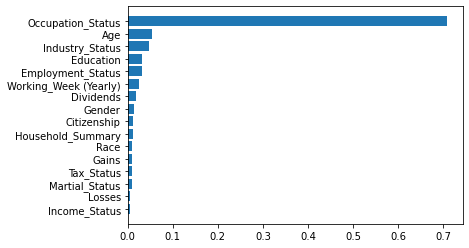

In [23]:
plt.barh(np.arange(len(importance_df)), importance_df)
plt.yticks(np.arange(len(importance_df)), importance_df.index)
plt.show()

[[0.64922369 0.35077631]
 [0.05616984 0.94383016]]


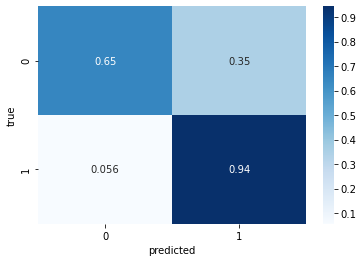

In [24]:
cm = confusion_matrix(val_y_nonzero, val_y_nonzero_hat, normalize='true')
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

### income 0을 1로 예측함

In [25]:
np.where(val_y_nonzero!=val_y_nonzero_hat)[0]
df1 = val_x.iloc[np.where(val_y_nonzero==val_y_nonzero_hat)[0]]
df2 = val_x.iloc[np.where(val_y_nonzero!=val_y_nonzero_hat)[0]]

In [26]:
check_1 = save_le.inverse_transform(df1['Occupation_Status'])
check_2 = save_le.inverse_transform(df2['Occupation_Status'])

In [28]:
check_1

array(['Unknown', 'Unknown', 'Admin Support (include Clerical)', ...,
       'Transportation', 'Unknown', 'Unknown'], dtype=object)

In [29]:
check_2

array(['Management', 'Professional', 'Craft & Repair', 'Professional',
       'Transportation', 'Admin Support (include Clerical)',
       'Craft & Repair', 'Services', 'Professional', 'Sales',
       'Professional', 'Farming & Forestry & Fishing', 'Professional',
       'Craft & Repair', 'Transportation', 'Services', 'Sales',
       'Professional', 'Admin Support (include Clerical)', 'Sales',
       'Transportation', 'Management', 'Management',
       'Admin Support (include Clerical)',
       'Admin Support (include Clerical)', 'Services', 'Sales',
       'Handlers/Cleaners', 'Handlers/Cleaners', 'Sales',
       'Transportation', 'Services', 'Services', 'Services', 'Management',
       'Sales', 'Machine Operators & Inspectors', 'Services', 'Services',
       'Services', 'Professional', 'Admin Support (include Clerical)',
       'Professional', 'Services', 'Admin Support (include Clerical)',
       'Management', 'Professional', 'Machine Operators & Inspectors',
       'Professional', 

In [27]:
def

SyntaxError: invalid syntax (<ipython-input-27-7b18d017f89f>, line 1)

### modify education
##### final train error : 456.20
##### final val error : 610.15

### modify income status 1
##### final train error : 459.07
##### final val error : 608.42

In [ ]:
final_pred = np.array(test_preds).mean(0)

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission

,ID,Income
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
9995,TEST_9995,0
9996,TEST_9996,0
9997,TEST_9997,0
9998,TEST_9998,0


In [ ]:
submission['Income'] = final_pred
submission

,ID,Income
0,TEST_0000,-1.367361
1,TEST_0001,31.340819
2,TEST_0002,407.449383
3,TEST_0003,621.593877
4,TEST_0004,3.033274
...,...,...
9995,TEST_9995,909.235724
9996,TEST_9996,817.979346
9997,TEST_9997,381.699638
9998,TEST_9998,3.033274


In [ ]:
os.makedirs('submission', exist_ok=True)
# submission.to_csv('submission/baseline_0314.csv', index=False)
submission.to_csv('submission/feat_engineering_0319_1.csv', index=False)